Preliminaries: importing the libraries.

In [1]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates



import numpy as np
import pandas as pd
import copy

from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl
from tslib.tests import testdata


In [2]:
def hsvt(X, rank): 
    u, s, v = np.linalg.svd(X, full_matrices=False)
    s[rank:].fill(0)
    return np.dot(u*s, v) 

Reading in the data and converting it into a usable form

In [3]:
directory = os.path.dirname(testdata.__file__)

filename = directory + '/prop99.csv'


df = pd.read_csv(filename)
df = df[df['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)']
pivot = df.pivot_table(values='Data_Value', index='LocationDesc', columns=['Year'])
dfProp99 = pd.DataFrame(pivot.to_records())

allColumns = dfProp99.columns.values

The code above extracts out the relevant portion for our analysis, and finally what we need looks like the following. 
This is the format that you should get your dataset into for analysis. One row per "unit", and one column for every timepoint.

In [4]:
pd.set_option('display.max_columns', 10)
dfProp99.head()

,LocationDesc,1970,1971,1972,1973,...,2010,2011,2012,2013,2014
0,Alabama,89.8,95.4,101.1,102.9,...,71.5,68.4,67.2,64.6,61.7
1,Alaska,121.3,123.0,130.0,125.8,...,43.8,43.3,41.2,39.0,37.2
2,Arizona,115.2,109.6,125.0,128.3,...,24.8,27.1,25.0,24.4,23.0
3,Arkansas,100.3,104.1,103.9,108.0,...,63.2,61.1,60.5,57.5,54.4
4,California,123.0,121.0,123.5,124.4,...,26.3,26.0,25.2,23.9,22.7


Now we extract the list of donor pools ("otherStates"), the intervention unit ("caStateKey"), the start and end year for the dataset and the year of the intervention.

In [5]:
states = list(np.unique(dfProp99['LocationDesc']))
years = np.delete(allColumns, [0])
caStateKey = 'California'
states.remove(caStateKey)
otherStates = states

yearStart = 1970
yearTrainEnd = 1989
yearTestEnd = 2015

p = 1.0

Now we prep the data and split it into training and test sets.

In [6]:
trainingYears = []
for i in range(yearStart, yearTrainEnd, 1):
	trainingYears.append(str(i))

testYears = []
for i in range(yearTrainEnd, yearTestEnd, 1):
	testYears.append(str(i))

trainDataMasterDict = {}
trainDataDict = {}
testDataDict = {}
for key in otherStates:
	series = dfProp99.loc[dfProp99['LocationDesc'] == key]

	trainDataMasterDict.update({key: series[trainingYears].values[0]})

	# randomly hide training data
	(trainData, pObservation) = tsUtils.randomlyHideValues(copy.deepcopy(trainDataMasterDict[key]), p)
	trainDataDict.update({key: trainData})
	testDataDict.update({key: series[testYears].values[0]})
series = dfProp99[dfProp99['LocationDesc'] == caStateKey]
trainDataMasterDict.update({caStateKey: series[trainingYears].values[0]})
trainDataDict.update({caStateKey: series[trainingYears].values[0]})
testDataDict.update({caStateKey: series[testYears].values[0]})

trainMasterDF = pd.DataFrame(data=trainDataMasterDict)
trainDF = pd.DataFrame(data=trainDataDict)
testDF = pd.DataFrame(data=testDataDict)


This is what the test and train matrices look like (in the library we represent each donor pool 
or intervention unit as a separate column, and each timepoint as a row)

In [7]:
trainDF.head()

,Alabama,Alaska,Arizona,Arkansas,Colorado,...,Washington,West Virginia,Wisconsin,Wyoming,California
0,89.8,121.3,115.2,100.3,124.8,...,96.7,114.5,106.4,132.2,123.0
1,95.4,123.0,109.6,104.1,125.5,...,97.0,111.5,105.4,131.7,121.0
2,101.1,130.0,125.0,103.9,134.3,...,88.5,117.5,108.8,140.0,123.5
3,102.9,125.8,128.3,108.0,137.9,...,91.0,116.6,109.5,141.2,124.4
4,108.2,130.4,133.1,109.7,132.8,...,98.6,119.9,111.8,145.8,126.7


In [8]:
testDF.head()

,Alabama,Alaska,Arizona,Arkansas,Colorado,...,Washington,West Virginia,Wisconsin,Wyoming,California
0,105.6,94.4,96.8,118.3,88.8,...,86.1,104.0,100.3,111.4,82.4
1,108.6,100.2,88.9,113.1,87.4,...,83.4,104.1,94.1,96.9,77.8
2,107.9,101.8,81.2,116.8,90.2,...,78.7,100.1,95.5,109.1,68.7
3,109.1,98.5,79.0,126.0,88.3,...,81.1,98.0,96.2,110.8,67.5
4,108.5,95.2,80.3,113.8,88.6,...,79.4,111.0,91.2,108.4,63.4


Next, we do a sanity check to see if the matrix is indeed low rank. It checks out and looks like we will need only about 4 singular values.

Text(0.5, 1.0, 'Singular Value Spectrum')

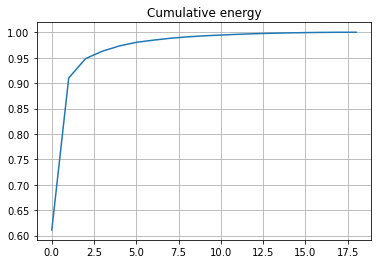

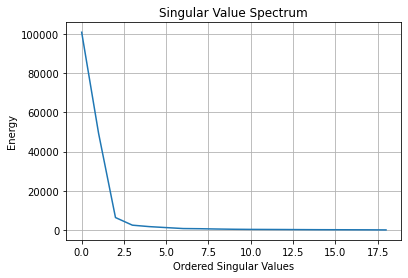

In [9]:
(U, s, Vh) = np.linalg.svd((trainDF) - np.mean(trainDF))
s2 = np.power(s, 2)
spectrum = np.cumsum(s2)/np.sum(s2)

plt.plot(spectrum)
plt.grid()
plt.title("Cumulative energy")
plt.figure()
#plt.rcParams["figure.figsize"] = [16,9]
plt.plot(s2)
plt.grid()


plt.xlabel("Ordered Singular Values") 
plt.ylabel("Energy")


plt.title("Singular Value Spectrum")

This is the all important step, now we create the synthetic control model.

In [10]:
singvals = 4
rscModel = RobustSyntheticControl(caStateKey, singvals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
rscModel.fit(trainDF)
denoisedDF = rscModel.model.denoisedDF()

Next up, getting the counterfactual predictions and model fit.

In [11]:
predictions = []
predictions = np.dot(testDF[otherStates], rscModel.model.weights)
predictions_noisy = np.dot(testDF[otherStates], rscModel.model.weights)
actual = dfProp99.loc[dfProp99['LocationDesc'] == caStateKey]
actual = actual.drop('LocationDesc', axis=1)
actual = actual.iloc[0]
model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)

And finally, the plot! That's it.

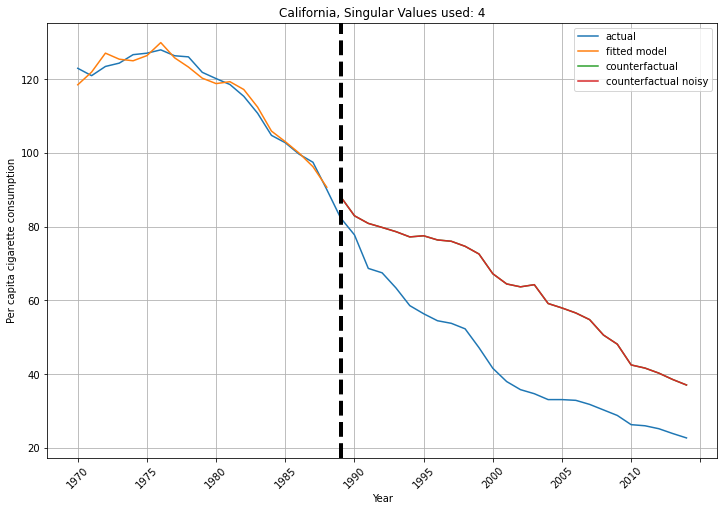

In [38]:
fig, ax = plt.subplots(1,1)
tick_spacing = 5
# this is a bug in matplotlib
label_markings = np.insert(years[::tick_spacing], 0, 'dummy')

ax.set_xticks(np.arange(len(label_markings)))
ax.set_xticklabels(label_markings, rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

plt.rcParams['figure.figsize'] = (12, 8.0)

plt.plot(years, actual ,label='actual')
plt.xlabel('Year')
plt.ylabel('Per capita cigarette consumption')
plt.plot(trainingYears, model_fit, label='fitted model')
plt.plot(testYears, predictions, label='counterfactual')
plt.plot(testYears, predictions_noisy, label='counterfactual noisy')
plt.title(caStateKey+', Singular Values used: '+str(singvals))

xposition = pd.to_datetime(yearTrainEnd,  errors='coerce')
plt.axvline(x=str(yearTrainEnd), color='k', linestyle='--', linewidth=4), plt.legend()
plt.grid()

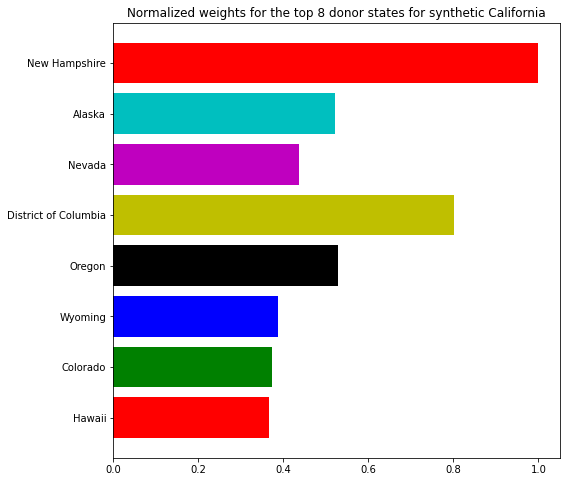

In [22]:
showstates=8
ind = np.argpartition(rscModel.model.weights, -showstates)[-showstates:]
topstates = [otherStates[i] for i in ind]
plt.figure(figsize=(8,8))

plt.barh(topstates, rscModel.model.weights[ind]/np.max(rscModel.model.weights), color=list('rgbkymc'))
plt.title("Normalized weights for the top "+str(showstates)+" donor states for synthetic California")
plt.show()

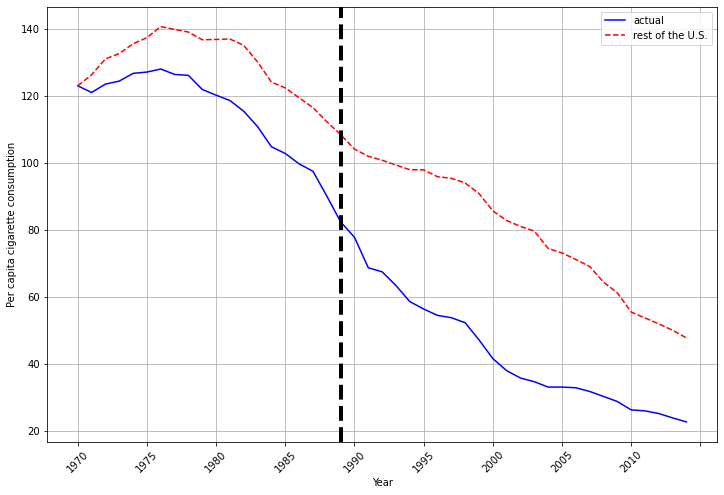

In [35]:
# AB testing


AB_df = dfProp99.copy()
AB_df = AB_df.drop([4], axis=0)
AB_series = AB_df.mean()
AB_series = AB_series * actual[0]/ AB_series[0]
#print(AB_series[0])
#print(actual[0])



#lt.plot(years,AB_series)


fig, ax = plt.subplots(1,1)
tick_spacing = 5
# this is a bug in matplotlib
label_markings = np.insert(years[::tick_spacing], 0, 'dummy')

ax.set_xticks(np.arange(len(label_markings)))
ax.set_xticklabels(label_markings, rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

plt.rcParams['figure.figsize'] = (12, 8.0)

plt.plot(years, actual ,label='actual',color = 'blue')
plt.xlabel('Year')
plt.ylabel('Per capita cigarette consumption')
plt.plot(years, AB_series, linestyle='--', color = 'red',label='rest of the U.S.') #label='fitted'
#plt.plot(testYears, predictions_noisy, label='counterfactual noisy')
#plt.title(caStateKey+', Singular Values used: '+str(singvals))

xposition = pd.to_datetime(yearTrainEnd,  errors='coerce')
plt.axvline(x=str(yearTrainEnd), color='k', linestyle='--', linewidth=4), plt.legend()
plt.grid()

